# First Baseball Analytics Check-in

**Goal**: Pick an advanced metric like ERA+, WHIP, WAR, etc., and calculate the metric for the season for the starting lineup of the Mariners

**Actual**: Created 2 functions for WHIP and other general pitching stats (no plots yet), as well as 3 functions that plot statcast data for a specific pitcher over a specific period of time, for pitch speed, pitch location, and a pitch speed heatmap over the location.

In [2]:
# Load baseball package
library("tidyverse", warn.conflicts=FALSE)
library("baseballr")

The documentation for the `baseballr` package can be found [here](https://billpetti.github.io/baseballr/)

#### Table of contents:

- Metric Function/Visualization
  - WHIP
  - General Pitching Stats
- Statcast Functions/Visualizations
  - Implementing Statcast Data
  - Plotting
    - Pitch Speed
    - Pitch Location
    - Pitch Location and Speed (Heatmap)

# Metric Function

## WHIP

Very basic I know, gotta start somewhere I suppose. I'll probably expand on this more later to take actual data from the API, although it's a little redundant given the next function.

In [3]:
whip <- function(hits, walks, innings){
    return((hits + walks) / innings)
}

In [4]:
whip(197, 71, 260)

[1] 1.030769

## General Pitching Stats

This function will provide the value of a specified stat for a pitcher over a given date range. There's no visualization for this yet as even over a date range it simply provides a single value for the entire range; I should be able to in the future have it plot the values by simply taking each day individually and then creating a range of them, as you can get daily stats just by having the same date as both the start and end input. There's another method for this using statcast, but the payload of data was too big for my computer to handle. It was way easier to get typical statcast data, show below, using baseballr. I chose Max Scherzer for the example because he consistently has a very good WHIP, a very good indicator of pitching performance.

In [5]:
my_pitching <- function(name, stat, start, end){
  pitcher_data <- bref_daily_pitcher(start, end)
  stat_df <- filter(pitcher_data, Name == name)
  return(suppressWarnings(select(stat_df, stat)[[1]]))
}

In [6]:
my_pitching("Max Scherzer", "WHIP", "2021-06-01", "2021-06-30")

2023-01-13 13:53:36: Invalid arguments or no daily pitcher data available!



ERROR: Error in UseMethod("filter"): no applicable method for 'filter' applied to an object of class "function"


# Statcast Functions/Visualizations

## Implementing Statcast Data

Using baseballr we can access Statcast data for any player during a given date range. I have noticed some bugs with this, at times it simply does not work for certain players, even by MLB ID. Félix Hernández (433587) would be a good example. Also, note that Statcast data did not start until 2015. I chose Yu Darvish as an example here as he is a good starting pitcher with a large pitch arsenal. A good example for a reliever across the same date range of June 2021 would be Paul Sewald.

In [7]:
my_statcast <- function(first, last, start, end){
  player_id <- playerid_lookup(last, first) %>%
    pull(mlbam_id)
  statcast_search_pitchers(start, end, player_id)
}

In [8]:
statcast_data <- my_statcast("Yu", "Darvish", "2021-06-01", "2021-06-30")

## Plotting

Before we functionalize and plot our Statcast data, we have to do four things. First, we need to add a new column in the data that is just the row numbers. This will act like a running pitch count across the date range. We then need to define a list of colors we can assign to pitches. These colors will be red for strikes, green for balls, and blue for balls in play (BIP). Next, we need to define some vectors of pitch type abbreviations that we can call in our functions to make things more clean. Finally, we need to do the same but with the outcomes of the pitches.

In [12]:
# Adds a column of row numbers to the Statcast data
plot_df <- statcast_data %>%
  map_df(rev) %>%
  mutate(Pitches = factor(row_number()))

# Separates outcome of pitch by color for use in plotting
my_colors = c("ball" = "springgreen3", "blocked_ball" = "springgreen3", 
              "hit_by_pitch" = "springgreen3", "called_strike" = "red2", 
              "swinging_strike" = "red2", "foul" = "red2", "foul_tip" = "red2",
              "swinging_strike_blocked" = "red2", "hit_into_play" = "blue")

# Types of pitches (4-seamers, sliders, etc.)
all_pitches <- unique(plot_df$pitch_type)
all_fastballs <- c("FF", "FC", "FA", "FT", "SI", "FS")
fast_fastballs <- c("FF", "FA", "FT")
slow_fastballs <- c("FC", "FS", "SI")
all_off_speed <- c("SL", "CU", "CB", "KC", "SC", "KU", "KN", "CH", "EP")
standard_off_speed <- c("SL", "CU", "CB", "CH")
uncommon_off_speed <- c("KC", "SC", "KU", "KN", "EP")  # "Junk"

# Pitch outcomes (strikes, balls, etc.)
all_outcomes <- unique(plot_df$description)
balls <- c("ball", "blocked_ball", "hit_by_pitch")
strikes <- c("called_strike", "swinging_strike", "foul", "foul_tip",
             "swinging_strike_blocked")
BIP <- "hit_into_play"
swing <- c("swinging_strike", "foul", "foul_tip", "swinging_strike_blocked",
           BIP)
no_swing <- c("ball", "blocked_ball", "hit_by_pitch", "called_strike")
in_the_dirt <- c("blocked_ball", "swinging_strike_blocked")
may_increase_obp <- c("ball", "blocked_ball", "hit_by_pitch", BIP)

### Pitch Speed

This function will plot the pitch speed across all pitches within the date range. The input for this function will be the above pitch types.

In [10]:
pitch_speed <- function(pitch, outcome){
  pitch_df <- filter(plot_df, pitch_type %in% pitch, description %in% outcome)
  ggplot(pitch_df, aes(as.numeric(as.character(Pitches)), release_speed, 
                       color=description)) +
    geom_point() +
    scale_color_manual(name = "Pitch\nResult", values = my_colors, 
                       breaks = c("ball", "called_strike", "hit_into_play"),
                       labels = c("Balls", "Strikes", "BIP")) +
    theme(axis.title.y = element_blank(), axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) +
    xlab("Pitches (Sequential Across Date Range)") +
    ggtitle("Pitch Release Speed in MPH (Balls, Strikes, BIP)") +
    scale_y_continuous(breaks = seq(floor(min(pitch_df$release_speed)),
                                    ceiling(max(pitch_df$release_speed)),
                                    by = 1))
}

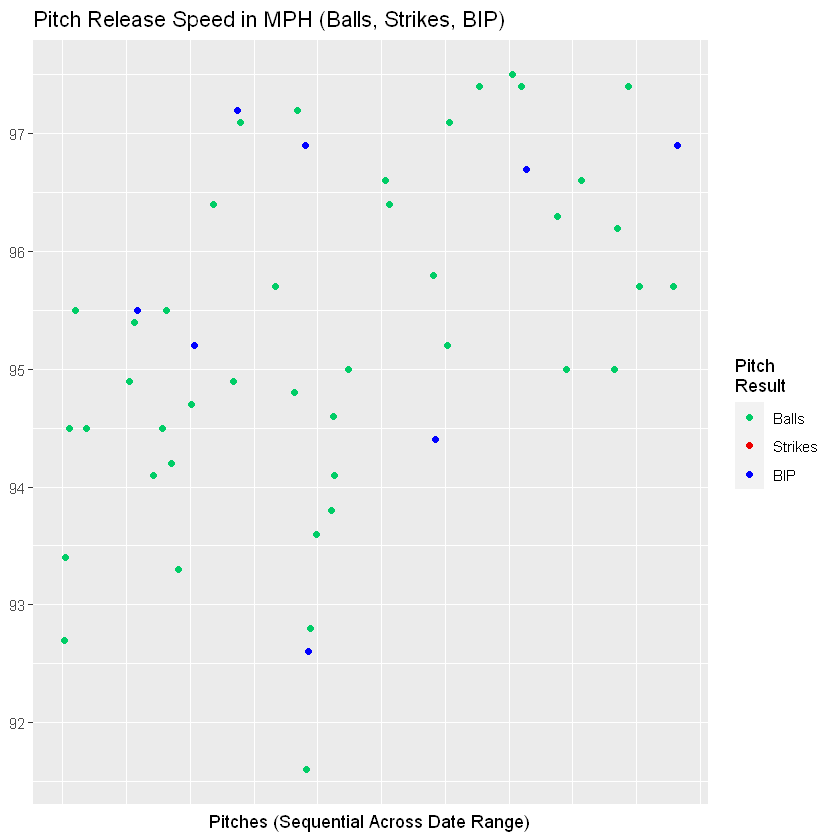

In [15]:
pitch_speed("FF", may_increase_obp)

### Pitch Location

This function will return the location of each pitch, from the batter's perspective facing the pitcher. I tried to get the scaling to be as good as possible, but it isn't perfect as the heigh -- and thus the ratio -- of the strike zone is variable.

In [17]:
pitch_location <- function(pitch, outcome){
  pitch_df <- filter(plot_df, pitch_type %in% pitch, description %in% outcome)
  plt <- ggplot(pitch_df, aes(plate_x, plate_z, color = description)) +
    geom_point() +
    xlim(-3.25, 3.25) +
    ylim(-1, 5) +
    scale_color_manual(name = "Pitch\nResult", values = my_colors, 
                       breaks = c("ball", "called_strike", "hit_into_play"),
                       labels = c("Balls", "Strikes", "BIP")) +
    theme(axis.title.y = element_blank(), axis.title.x = element_blank()) +
    ggtitle("Pitch Location from Batter's Perspective (Balls, Strikes, BIP)")
  suppressWarnings(print(plt))
}

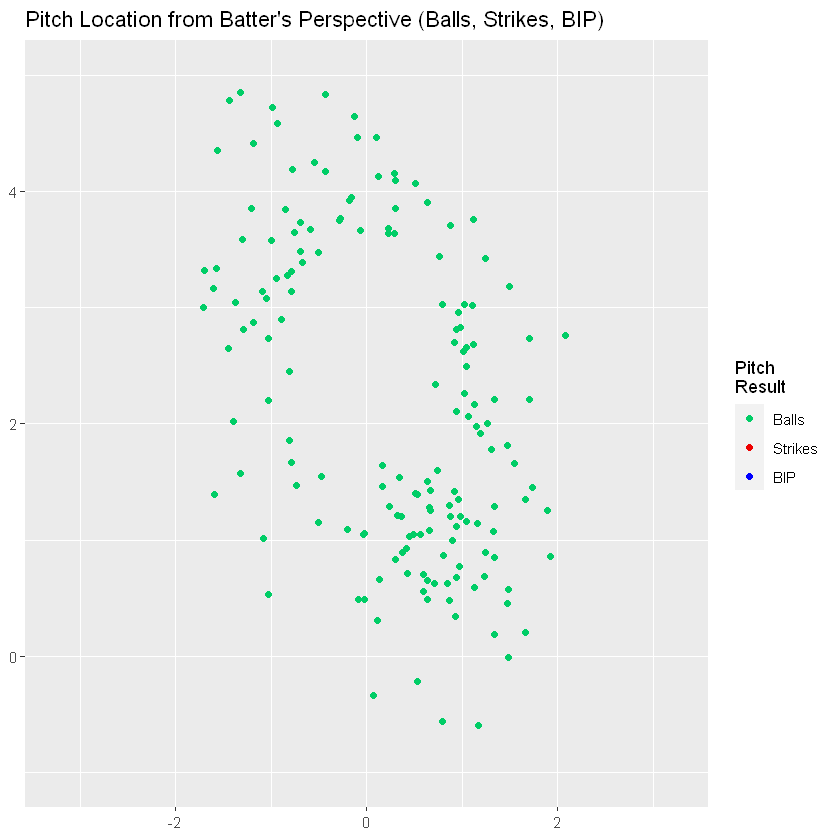

In [21]:
pitch_location(all_pitches, balls)

### Pitch Location and Speed (Heatmap)

This last function will do the same as the previous one, but instead of the colors representing the outcome of the pitch, there will be a gradient respresenting the speed of the pitch. Like before, I tried to get the scaling as good as possible. I don't think this function is as useful as I would have been, as it can be hard to distinguish between values in the gradient, and there are quite a few outliers that mess up the scaling. I may try and improve it in the future.

In [94]:
pitch_location_speed <- function(pitch, outcome){
  pitch_df <- filter(plot_df, pitch_type %in% pitch, description %in% outcome)
  plt <- ggplot(pitch_df, aes(plate_x, plate_z, color = release_speed)) +
    geom_point() +
    xlim(-3.25, 3.25) +
    ylim(-1, 5) +
    scale_color_gradient(name = "Pitch\nSpeed", low = "lightgoldenrodyellow",
                         high = "orangered3", breaks =
                         seq(70, ceiling(max(pitch_df$release_speed)), 
                             by = 5)) +
    theme(axis.title.y = element_blank(), axis.title.x = element_blank()) +
    ggtitle("Pitch Location from Batter's Perspective (Speed in MPH)")
  suppressWarnings(print(plt))
}

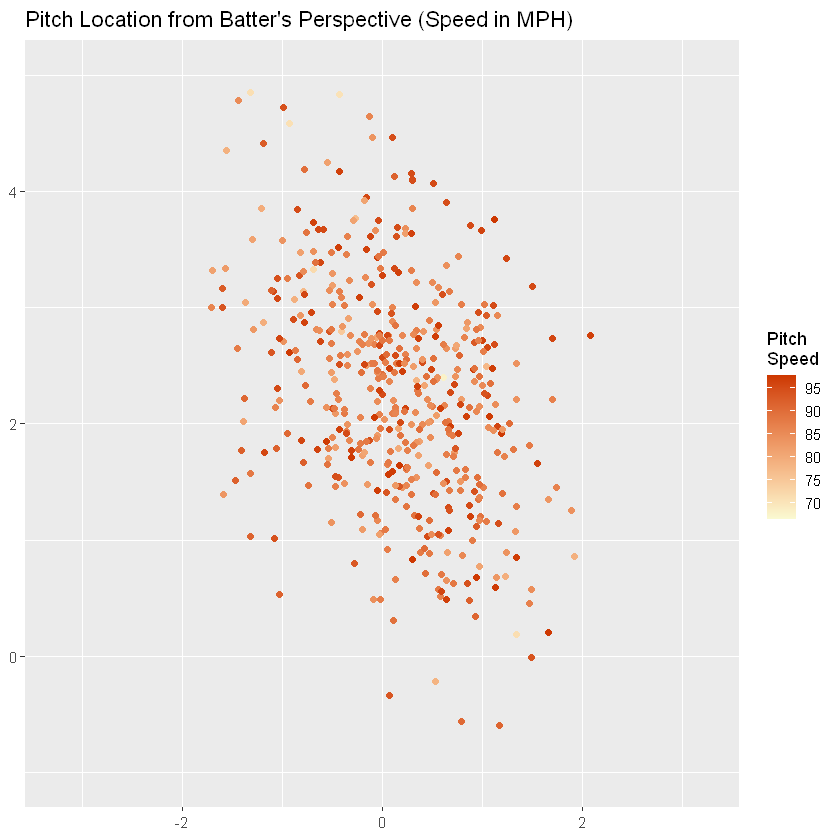

In [95]:
pitch_location_speed(all_pitches, all_outcomes)